# MLP model with new data

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from livemodel_mlp import Preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, ReLU, Dropout, Softmax
from tensorflow.math import confusion_matrix

## Load Data

In [14]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

file_names = ['../dataset/log.csv']

file_paths = [os.path.join(root_path, os.path.join('dataset', f)) for f in file_names]

In [16]:
x_names = ['L%d%c' % (i, c) for i in range(21) for c in ['x', 'y', 'z']]
y_names = ['a', 's', 'd', 'f']

col_names = x_names + y_names

dfs = [pd.read_csv(f, names=col_names) for f in file_paths]
df = pd.concat(dfs, axis=0)

df = df.dropna()

# df = df.sample(frac=1).reset_index(drop=True)

In [18]:
df

,L0x,L0y,L0z,L1x,L1y,L1z,L2x,L2y,L2z,L3x,...,L19x,L19y,L19z,L20x,L20y,L20z,a,s,d,f
0,0.316644,0.682168,-0.000088,0.395992,0.651340,-0.053197,0.445027,0.578035,-0.117116,0.465275,...,0.253054,0.334646,-0.195741,0.273054,0.297351,-0.191549,0,0,0,0
1,0.313333,0.688498,-0.000080,0.394191,0.650993,-0.043841,0.441437,0.582658,-0.097760,0.463732,...,0.248506,0.335806,-0.177995,0.275994,0.297730,-0.170261,0,0,0,0
2,0.310459,0.695964,-0.000089,0.392642,0.660708,-0.044871,0.441216,0.586844,-0.095954,0.463317,...,0.243776,0.340959,-0.165032,0.267159,0.300819,-0.157857,0,0,0,0
3,0.312947,0.692926,-0.000077,0.394296,0.656957,-0.042094,0.442790,0.583110,-0.092982,0.465135,...,0.246290,0.336287,-0.158003,0.269776,0.294793,-0.150561,0,0,0,0
4,0.314142,0.687548,-0.000078,0.396699,0.653338,-0.044487,0.444446,0.578224,-0.095149,0.465957,...,0.248816,0.334747,-0.152839,0.272201,0.294824,-0.144670,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,0.275240,0.664240,0.000031,0.348321,0.599708,-0.063883,0.376346,0.504037,-0.100509,0.387700,...,0.127375,0.310920,-0.053242,0.127495,0.256351,-0.057914,0,0,0,0
3016,0.260265,0.645565,-0.000057,0.333423,0.578507,-0.060416,0.359872,0.478559,-0.101887,0.370371,...,0.116524,0.288137,-0.012237,0.128050,0.238952,-0.005522,0,0,0,0
3017,0.241285,0.627128,-0.000091,0.317014,0.562212,-0.055210,0.345285,0.462058,-0.095780,0.357599,...,0.096197,0.262902,0.006306,0.106649,0.215878,0.014724,0,0,0,0
3018,0.230411,0.611018,-0.000062,0.309409,0.544490,-0.063915,0.336805,0.445054,-0.108294,0.345611,...,0.076120,0.241248,-0.016524,0.085876,0.191267,-0.014317,0,0,0,0


## Preprocessing

In [20]:
# add 'none' label
df['none'] = (df.a + df.s + df.d + df.f == 0).astype(int)

y_names.append('none')
col_names.append('none')

In [22]:
none_idx = df[df.none == 1].index

mask = np.arange(0, len(none_idx))
np.random.shuffle(mask)

drop_rate = 0.6
drop_len = int(len(none_idx)*drop_rate)
drop_idx = none_idx[mask[:drop_len]]

df = df.drop(drop_idx, axis=0).reset_index(drop=True)

In [24]:
# x-y split
x_df, y_df = df[x_names], df[y_names]

print('x_df:', x_df.shape)
print('y_df:', y_df.shape)

x_df: (2216, 63)
y_df: (2216, 5)


In [26]:
# stratified train-test split
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# train_idx, test_idx = next(sss.split(x_df, y_df))

# x_train = x_df.loc[train_idx].values
# y_train = y_df.loc[train_idx].values

# x_test = x_df.loc[test_idx].values
# y_test = y_df.loc[test_idx].values

# print('x_train:', x_train.shape)
# print('y_train:', y_train.shape)
# print('x_test:', x_test.shape)
# print('y_test:', y_test.shape)

train_length = len(df) - 500

train, test = df[:train_length], df[train_length:]

train = train.sample(frac=1).reset_index(drop=True)

x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]

x_train = x_train.values
y_train = y_train.values

x_test = x_test.values
y_test = y_test.values

In [28]:
# hands data preprocessor
preprocessor = Preprocessing(gamma_smoothing=True,
                             fixed_minmax=True,
                             fixed_minmax_filepath=file_names[0])

In [30]:
results = []
for x in (x_train, x_test):
    result = []
    for row in x:
        res = preprocessor.process(row)
        result.append(res)
    results.append(result)
    preprocessor.reset()

x_train = np.array(results[0])
x_test  = np.array(results[1])

## Model

In [31]:
model = Sequential([
    InputLayer(input_shape=(63,)),


    # Dense(32, kernel_initializer='he_normal'),
    # BatchNormalization(),
    # ReLU(),
    # Dropout(0.5),

    Dense(16, kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),

    # Dense(5, kernel_initializer='he_normal'),
    # BatchNormalization(),
    # ReLU(),
    # Dropout(0.5),

    Dense(5, kernel_initializer='he_normal'),
    Softmax()
])

In [32]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
43/43 [==============================] - 1s 6ms/step - loss: 1.7290 - accuracy: 0.2835 - val_loss: 1.6571 - val_accuracy: 0.2209
Epoch 2/50
43/43 [==============================] - 0s 2ms/step - loss: 1.3952 - accuracy: 0.4366 - val_loss: 1.6314 - val_accuracy: 0.2209
Epoch 3/50
43/43 [==============================] - 0s 2ms/step - loss: 1.2465 - accuracy: 0.4934 - val_loss: 1.5763 - val_accuracy: 0.2238
Epoch 4/50
43/43 [==============================] - 0s 2ms/step - loss: 1.1696 - accuracy: 0.5583 - val_loss: 1.4886 - val_accuracy: 0.2616
Epoch 5/50
43/43 [==============================] - 0s 2ms/step - loss: 1.1236 - accuracy: 0.5875 - val_loss: 1.4409 - val_accuracy: 0.3198
Epoch 6/50
43/43 [==============================] - 0s 2ms/step - loss: 1.0882 - accuracy: 0.5984 - val_loss: 1.3413 - val_accuracy: 0.4942
Epoch 7/50
43/43 [==============================] - 0s 2ms/step - loss: 1.0655 - accuracy: 0.6188 - val_loss: 1.2843 - val_accuracy: 0.5262
Epoch 8/50
43/43 [==

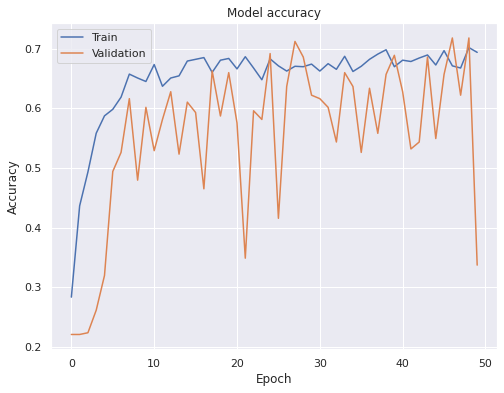

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [35]:
model.evaluate(x_test, y_test, verbose=2)

16/16 - 0s - loss: 0.8002 - accuracy: 0.7000


[0.8002359867095947, 0.699999988079071]

In [36]:
predict = model.predict(x_test)

In [37]:
model.save('saved_model/new_model_mlp3.h5')

In [38]:
conf_predict = []
conf_y_test = []

for i in range(len(predict)):
    conf_predict.append(predict[i].argmax())
    conf_y_test.append(y_test[i].argmax())

conf = confusion_matrix(conf_y_test, conf_predict).numpy()

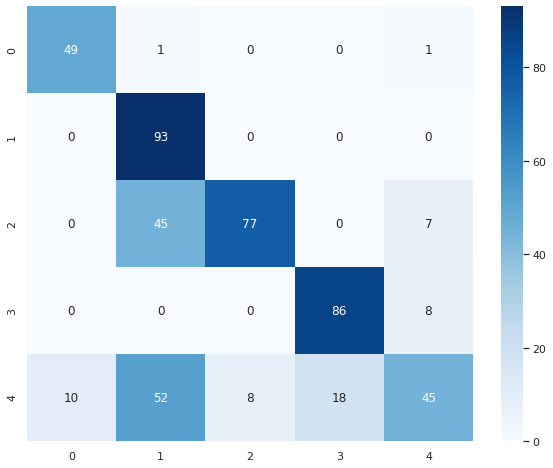

In [39]:
sns.set(rc={'figure.figsize':(10, 8)})

labels = [f'{val:d}' for val in conf.flatten()]
labels = np.array(labels).reshape(5, 5)

sns.heatmap(conf, annot=labels, fmt='', cmap='Blues')
plt.show()

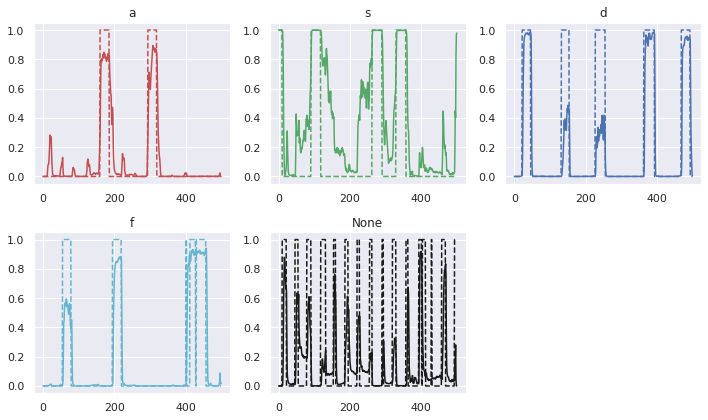

In [40]:
import matplotlib.pyplot as plt

size = len(y_test)

fig = plt.figure(figsize=(10,6))

keys = [('r', "a"), ('g', "s"), ('b', "d"), ('c', "f"), ('k', "None")]

for i, (color, key_class) in enumerate(keys):
    k = fig.add_subplot(2,3,i+1)
    k.set_title(key_class)
    k.plot(range(size), y_test[:,i], color+'--')
    k.plot(range(size), predict[:,i], color) 

plt.tight_layout()
plt.show()